In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from scipy.interpolate import CubicSpline,interp1d,InterpolatedUnivariateSpline
import time
import math as m
import copy
from scipy.interpolate import interp1d
import os
import psutil

In [5]:
# Model parameters
beta = 0.99
alpha = 0.36
delta = 0.025
k0 = 12.5
A = 2
h0 = 0.53
rho = 0.95
sigma_eps = 0.000049
gamma = 0.5
egam = 1-1/gamma
nu = 0.36

# Numerical parameters
k_l = 10.0 #lower bound for capital
k_u = 40.0 #upper bound for capital
tol = 1e-6 #tolerance for policy function convergence
itermax = 2000

# Computational variables variables
TT = 360
eta_dim = 21 #Number of productivty states
grid_res = 1000 #capital grid resolution
verbose = True
n_err = 10000 #

In [6]:
def discretize_AR(rho, mu, sigma_eps, n, return_stationary_dist=False):
    """
    Discretizes an AR(1) process using the Rouwenhorst method.

    Args:
        rho:           AR(1) coefficient
        mu:            unconditional mean
        sigma_eps:     std. dev. of the shock
        n:             number of grid points
        return_stationary_dist: if True, returns the stationary distribution

    Returns:
        z:  (n,) grid of discrete values
        pi: (n,n) Markov transition matrix
        w:  (n,) stationary distribution (if requested)
    """
    def rouwenhorst_matrix(rho, n):
        p = (1. + rho) / 2.
        if n == 2:
            return np.array([[p, 1 - p],
                             [1 - p, p]])
        else:
            Pi_n_minus_1 = rouwenhorst_matrix(rho, n - 1)
            Pi = np.zeros((n, n))
            Pi[:-1, :-1]   += p      * Pi_n_minus_1
            Pi[:-1, 1:]    += (1-p)  * Pi_n_minus_1
            Pi[1:, :-1]    += (1-p)  * Pi_n_minus_1
            Pi[1:, 1:]     += p      * Pi_n_minus_1
            Pi[1:-1, :]   /= 2.
            return Pi

    sigma_eta = sigma_eps / (1 - rho**2)
    pi = rouwenhorst_matrix(rho, n)

    psi = np.sqrt(n - 1) * m.sqrt(sigma_eta)
    z = np.zeros(n)
    for i in range(n):
        z[i] = -psi + 2*psi*i/(n-1) + mu

    # Find stationary distribution by repeated multiprlication with the transition vector to find stationary distribution
    if return_stationary_dist:
        w = np.ones(n) / n
        for _ in range(10000):
            w = pi.T @ w
        return z, pi, w
    else:
        return z, pi

#Testing the function with different values
z, pi, w = discretize_AR(rho = 0.9, mu = 0.2, sigma_eps = 0.1, n = 5, return_stationary_dist=True)
print(z, pi, w)

import numpy as np

def simulate_AR(pi, T, seed):
    """
    Simulates a Markov process using a transition matrix (0-based indexing).

    Parameters
    ----------
    pi : ndarray of shape (n, n)
        Transition matrix where each row sums to 1.
    T : int
        Number of periods to simulate.
    fixed : bool, optional
        Whether to set a fixed random seed for reproducibility.

    Returns
    -------
    shocks : ndarray of int
        Simulated state indices (0-based).
    """
    np.random.seed(seed)

    n = pi.shape[0]
    assert pi.shape[0] == pi.shape[1], "Transition matrix must be square"

    shocks = np.zeros(T, dtype=int)
    shocks[0] = n // 2  # 0-based: start in middle state
    for t in range(1, T):
        shocks[t] = get_tomorrow(pi[shocks[t - 1]])
    return shocks


def get_tomorrow(row_pi):
    """
    Draws a state index (0-based) from a probability row.

    Parameters
    ----------
    row_pi : ndarray of shape (n,)
        Transition probabilities from current state.

    Returns
    -------
    idx : int
        Next state index (0-based).
    """
    rand = np.random.rand()
    cum_probs = np.cumsum(row_pi)
    return np.searchsorted(cum_probs, rand)

print(simulate_AR(pi, TT, 42))

[-1.2509525  -0.52547625  0.2         0.92547625  1.6509525 ] [[8.1450625e-01 1.7147500e-01 1.3537500e-02 4.7500000e-04 6.2500000e-06]
 [4.2868750e-02 8.2127500e-01 1.2896250e-01 6.7750000e-03 1.1875000e-04]
 [2.2562500e-03 8.5975000e-02 8.2353750e-01 8.5975000e-02 2.2562500e-03]
 [1.1875000e-04 6.7750000e-03 1.2896250e-01 8.2127500e-01 4.2868750e-02]
 [6.2500000e-06 4.7500000e-04 1.3537500e-02 1.7147500e-01 8.1450625e-01]] [0.0625 0.25   0.375  0.25   0.0625]
[2 2 3 3 3 3 3 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 3 3
 3 2 2 2 2 2 1 2 2 2 2 2 2 2 3 3 3 3 3 3 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 2 2 2 2 2 3 4 4 4 4 4 3 3
 3 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 2 2 2 2 1 1 1 0 0 0 0 0 0 0 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 1 1 1 2 3 3 3 2 3 3 4 4 4 4 4 4 4 3 3 3 3
 3 2 2 3 3

In [7]:
# Create grid with shocks and transition matrix
grid_eta, pi = discretize_AR(rho, 0, sigma_eps, eta_dim, return_stationary_dist=False)

# Create the grid for k and define policy function
grid_k = np.linspace(k_l, k_u, grid_res)

In [8]:
###############################Initialize policy functions ############################################################################################
l = np.zeros((grid_res, eta_dim))
c = np.zeros((grid_res, eta_dim))
c_new = np.zeros((grid_res, eta_dim))

for i in range(eta_dim):  #create a policy function for every state eta
    l[:,i] = 0.3
    #c[:,i] = 1
    c[:,i] = np.exp(grid_eta[i]) * ((grid_k)**alpha) * (l[:,i])**(1-alpha)
    c_new[:,i] = copy.deepcopy(c[:,i])

##############################Function to interpolate RHS##############################################################################################
def interpolate_RHS(consumption, labor, eta, dim=3):
    """
    Interpolates the right hand side of the Euler equation.

    Parameters
    ----------
    consumption : ndarray of shape (n,m)
        policy function for consumption
    labor : ndarray of shape (n,m)
        policy function for labor

    Returns
    -------
    RHS : ndarray of shape (n,m)
        RHS for state g and capital k
    coeff_r : a list of spline objects (one for each state g)
        RHS for state g and capital k
    """
    RHS = np.zeros((grid_res, eta_dim))
    coeff_r = np.zeros(eta_dim)
    for g in range(eta_dim):
        for k in range(grid_res):
            marg_util = nu * (consumption[k, :]**nu * (1-np.array(labor[k, :]))**(1-nu))**egam / consumption[k, :]
            rhs_vec = pi[g, :] * (1 + np.exp(eta[:]) * alpha * (grid_k[k] / labor[k, :])**(alpha-1) - delta) * marg_util
            RHS[k, g] = beta * np.sum(rhs_vec)
            RHS[k, g] = RHS[k, g]**(-gamma)

        # Spline interpolation for this is_
    if dim == 1:
        coeff_r = [interp1d(grid_k, RHS[:, g], kind='linear', fill_value='extrapolate', assume_sorted=True) for g in range(eta_dim)]
    if dim == 3:
        coeff_r = [CubicSpline(grid_k, RHS[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
    

    return RHS, coeff_r

def foc(l, k, g, spline_rhs, rhs_):
    # Calculate current consumption (same as in your foc)
    c_act = nu/(1-nu) * (1-l) * np.exp(grid_eta[g]) * (1-alpha) * (k/l)**alpha

    # Calculate kplus (future capital)
    kplus = (1-delta)*k + np.exp(grid_eta[g])*k**alpha * l**(1-alpha) - c_act

    # Evaluate spline at min(kplus, k_u)
    spline = spline_rhs[g]
    k_eval = min(kplus, k_u)
    foc_val = spline_rhs[g](k_eval)

    # Linear extrapolation for kplus > k_u
    if kplus > k_u:
        diff = (rhs_[grid_res-1, g] - rhs_[grid_res-2, g]) / (grid_k[grid_res-1] - grid_k[grid_res-2])
        foc_val += diff * (kplus - k_u)
    foc_val = foc_val ** (-1/gamma)

    # The first order condition
    return nu * (c_act**nu * (1-l)**(1-nu))**egam / c_act - foc_val

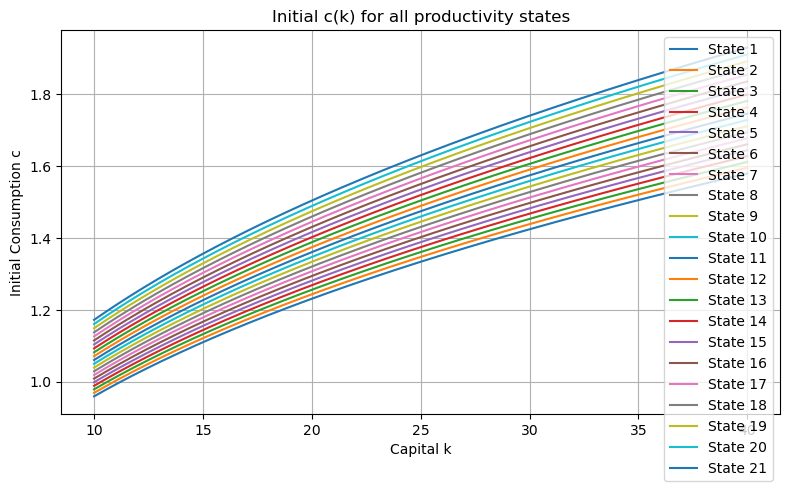

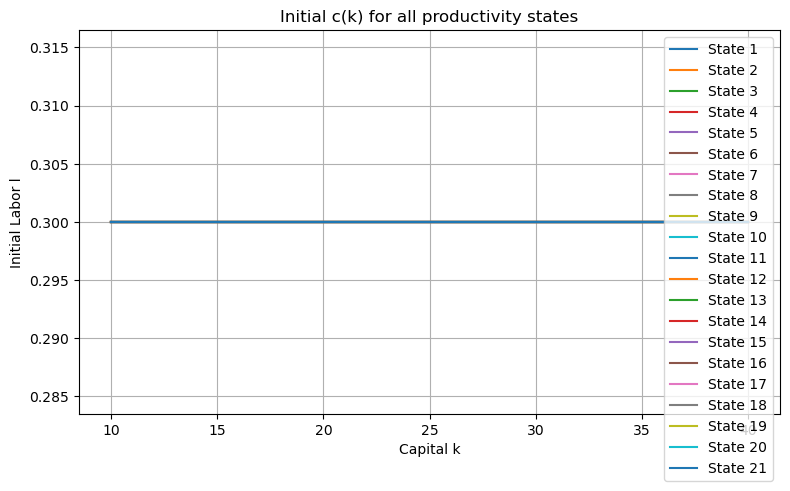

In [9]:


# Plot
plt.figure(figsize=(8, 5))
for i in range(eta_dim):
    plt.plot(grid_k, c[:, i], label=f"State {i+1}")

plt.xlabel('Capital k')
plt.ylabel('Initial Consumption c')
plt.title('Initial c(k) for all productivity states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot
plt.figure(figsize=(8, 5))
for i in range(eta_dim):
    plt.plot(grid_k, l[:, i], label=f"State {i+1}")
plt.xlabel('Capital k')
plt.ylabel('Initial Labor l')
plt.title('Initial c(k) for all productivity states')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Iteration    1, Convergence level:   0.05291013
Iteration    2, Convergence level:   0.01430866
Iteration    3, Convergence level:   0.01358690
Iteration    4, Convergence level:   0.01289055
Iteration    5, Convergence level:   0.01221988
Iteration    6, Convergence level:   0.01157512
Iteration    7, Convergence level:   0.01095639
Iteration    8, Convergence level:   0.01036371
Iteration    9, Convergence level:   0.00979696
Iteration   10, Convergence level:   0.00925592
Iteration   11, Convergence level:   0.00874024
Iteration   12, Convergence level:   0.00824945
Iteration   13, Convergence level:   0.00778300
Iteration   14, Convergence level:   0.00734026
Iteration   15, Convergence level:   0.00692051
Iteration   16, Convergence level:   0.00652299
Iteration   17, Convergence level:   0.00614689
Iteration   18, Convergence level:   0.00579136
Iteration   19, Convergence level:   0.00545563
Iteration   20, Convergence level:   0.00513900
Iteration   21, Convergence level:   0.0

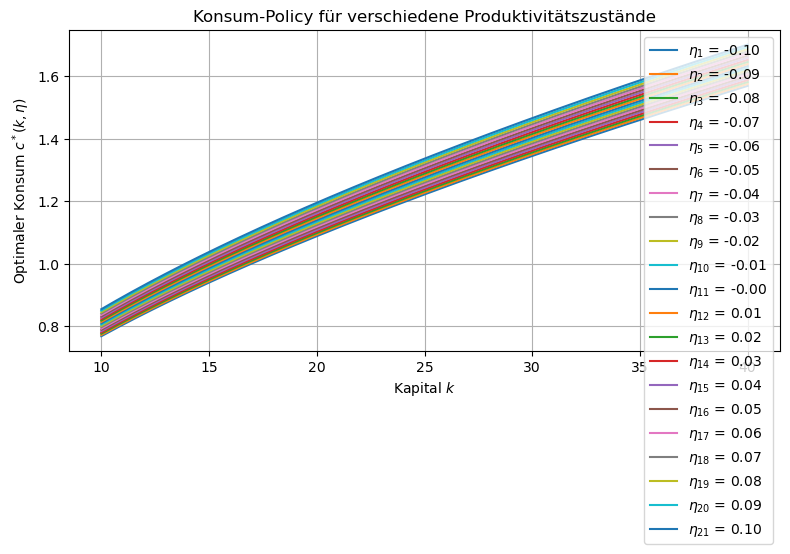

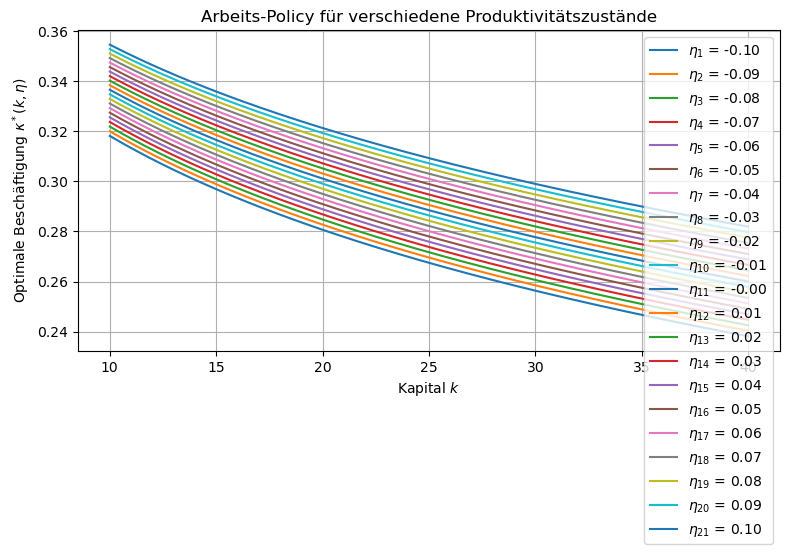

In [10]:
# Use timer to measure convergence time
t0 = time.time()     

for it in range(itermax):
    ############################Interpolate policy functions#########################################################################
    RHS_temp, coeff_temp = interpolate_RHS(c_new, l, grid_eta, 1)
    
    for j in range(grid_res):
        for g in range(eta_dim):
            fa = foc(1e-3, grid_k[j], g, coeff_temp, RHS_temp)
            fb = foc(1-1e-3, grid_k[j], g, coeff_temp, RHS_temp)
    
            if fa * fb > 0:
                print(f"Warning: No root at grid_k[{j}]={grid_k[j]:.3f} and eta[{g}]={grid_eta[g]:.3f}: FOC at min={fa:.3e}, max={fb:.3e}, iteration={it}")
                # fallback: assign the feasible endpoint (often max or min, or previous c[i])
                continue
            try:
                sol = root_scalar(foc, args=(grid_k[j], g, coeff_temp, RHS_temp), bracket=[1e-3, 1-1e-3], method='brentq')
                if sol.converged:
                    l_star = sol.root
                    if l_star >= 1:
                        l_star=1
                else:
                    l_star = copy.deepcopy(l[j, g])  # fallback if not converged
            except Exception:
                print(f"Root finding failed at g = {g} and j = {j}")
                      #Use previous guess for the specific point where it did not work and hope function will converge anyway
                l_star = copy.deepcopy(l[j, g])  # fallback
    
            l[j, g] = copy.deepcopy(l_star)
            
            # Calculate optimal consumption
            c_new[j, g] = nu/(1-nu)*(1-l_star)*np.exp(grid_eta[g])*(1-alpha)*(grid_k[j]/l_star)**alpha
            
    # Convergence check for the objective function
    diff = np.abs(c_new - c) / np.maximum(np.abs(c_new), 1e-10)
    con_lev = np.max(diff)
    if verbose:
        print(f"Iteration {it+1:4d}, Convergence level: {con_lev:12.8f}")

    if con_lev < tol:
        print(f"Converged after {it+1} iterations")
        break


    c = copy.deepcopy(c_new)

    # Plot für Konsumfunktion c_new
#    plt.figure(figsize=(8,5))
#    for g in range(eta_dim):
#        plt.plot(grid_k, c[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
#    plt.xlabel(r'Kapital $k$')
#    plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
#    plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
#    plt.legend()
#    plt.grid(True)
#    plt.tight_layout()
#    plt.show()
#    
#    plt.figure(figsize=(8,5))
#    for g in range(eta_dim):
#        plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
#    plt.xlabel(r'Kapital $k$')
#    plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
#    plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
#    plt.legend()
#    plt.grid(True)
#    plt.tight_layout()
#    plt.show()
else:
    print("No convergence")

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, c_new[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimaler Konsum $c^*(k,\eta)$')
plt.title('Konsum-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
for g in range(eta_dim):
    plt.plot(grid_k, l[:, g], label=fr'$\eta_{{{g+1}}}$ = {grid_eta[g]:.2f}')
plt.xlabel(r'Kapital $k$')
plt.ylabel(r'Optimale Beschäftigung $\kappa^*(k,\eta)$')
plt.title('Arbeits-Policy für verschiedene Produktivitätszustände')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

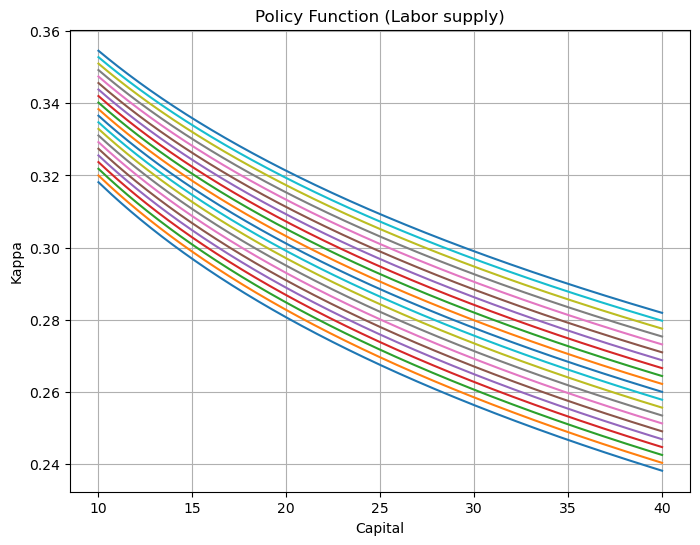

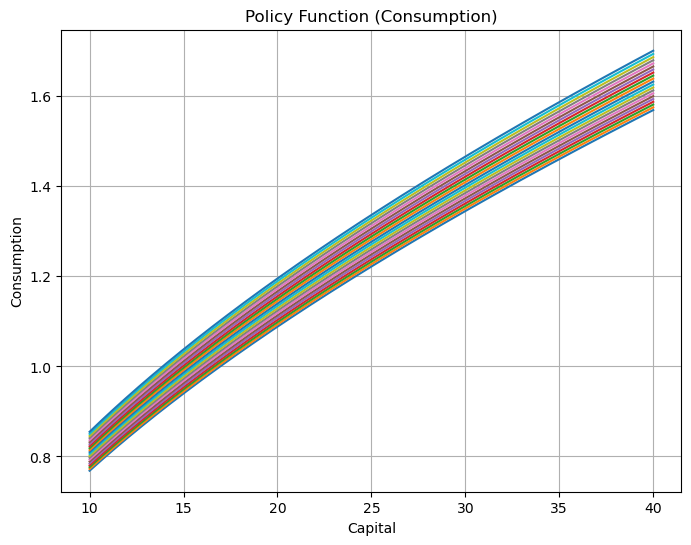

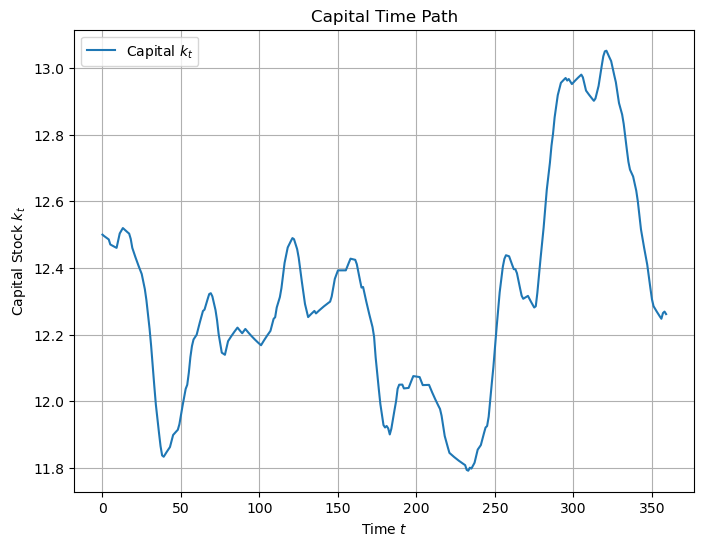

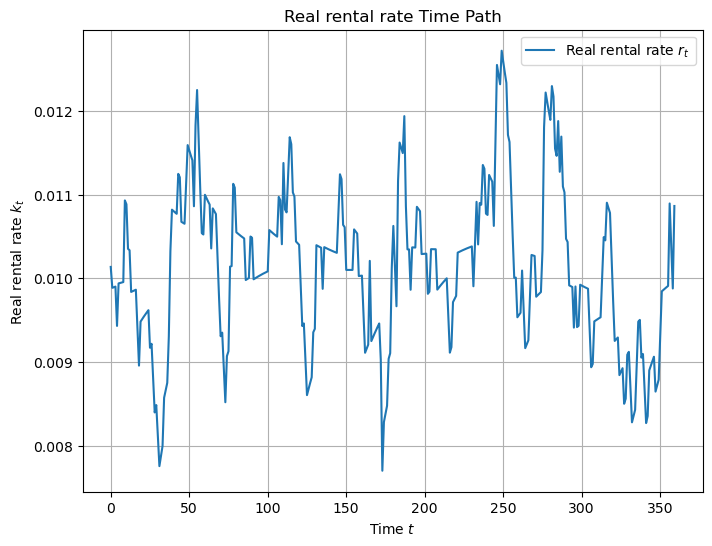

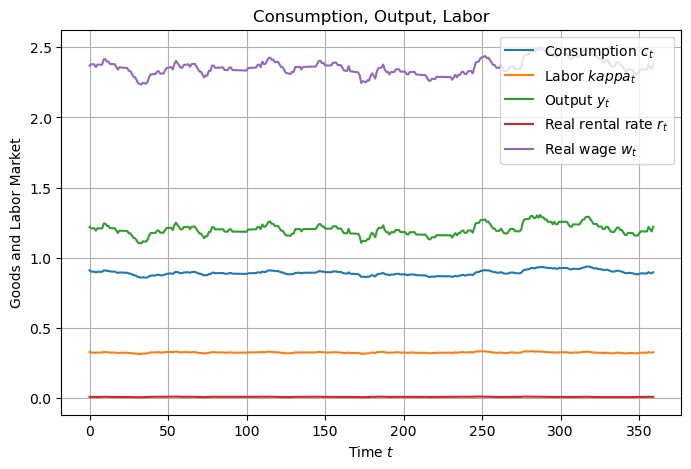

In [18]:
# Calculate steady states
#
#
#
#


# Calculate the time path of consumption and capital numerically
#Simulate series of stochastic shocks
eta_t = np.zeros(TT)
shock_series = simulate_AR(pi, TT, 1011)
c_interp = [CubicSpline(grid_k, c[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
l_interp = [CubicSpline(grid_k, l[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
k_t = np.zeros(TT)
l_t = np.zeros(TT)
r_t = np.zeros(TT)
w_t = np.zeros(TT)
c_t = np.zeros(TT)
i_t = np.zeros(TT)
y_t = np.zeros(TT)
k_t[0] = k0
eta_t[0] = 0
c_t[0] = c_interp[12](k_t[0])
l_t[0] = l_interp[12](k_t[0])
y_t[0] = np.exp(eta_t[0])*k_t[0]**alpha*l_t[0]**(1-alpha)
r_t[0] = np.exp(eta_t[0])*alpha*(l_t[0]/k_t[0])**(1-alpha) - delta
w_t[0] = np.exp(eta_t[0])*(1-alpha)*(k_t[0]/l_t[0])**(alpha)
i_t[0] = y_t[0] - c_t[0]
for it in range(1, TT):
    state = shock_series[it]
    eta_t[it] = grid_eta[state]
    k_t[it] = (1-delta)*k_t[it-1] + i_t[it-1]
    c_t[it] = c_interp[state](k_t[it])
    l_t[it] = l_interp[state](k_t[it])
    y_t[it] = np.exp(eta_t[it])*k_t[it]**alpha*l_t[it]**(1-alpha)
    i_t[it] = y_t[it] - c_t[it]
    r_t[it] = np.exp(eta_t[it])*alpha*(l_t[it]/k_t[it])**(1-alpha) - delta
    w_t[it] = np.exp(eta_t[it])*(1-alpha)*(k_t[it]/l_t[it])**(alpha)


# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, l)
plt.title("Policy Function (Labor supply)")
plt.xlabel("Capital")
plt.ylabel("Kappa")
plt.grid(True)
plt.show()

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption")
plt.grid(True)
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), k_t, label='Capital $k_t$')
#plt.plot([0, TT-1], [k_stat, k_stat], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Capital Stock $k_t$')
plt.legend()
plt.grid()
plt.title('Capital Time Path')
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), r_t, label='Real rental rate $r_t$')
#plt.plot([0, TT-1], [k_stat, k_stat], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Real rental rate $k_t$')
plt.legend()
plt.grid()
plt.title('Real rental rate Time Path')
plt.show()

# Plot time paths for goods market
plt.figure(figsize=(8, 5))
plt.plot(range(TT), c_t, label='Consumption $c_t$')
plt.plot(range(TT), l_t, label='Labor $kappa_t$')
#plt.plot(range(TT), c_t + delta * k_t, label='Consumption + repl. Inv.')
plt.plot(range(TT), y_t, label='Output $y_t$')
plt.plot(range(TT), r_t, label='Real rental rate $r_t$')
plt.plot(range(TT), w_t, label='Real wage $w_t$')
plt.xlabel('Time $t$')
plt.ylabel('Goods and Labor Market')
plt.legend()
plt.grid()
plt.title('Consumption, Output, Labor')
plt.show()

# Calculate Euler equation error
#err = 0
#grid = np.linspace(k_l, k_u, n_err)
#c_err = np.zeros(n_err)
#for i in range(n_err):
#    c_err[i] = spline_c(grid[i])
#splines = InterpolatedUnivariateSpline(grid, c_err, k=3)
#
#for ik in range(n_err):
#    k_com = k_l + (k_u - k_l) * ik / n_err
#    c_err_val = splines(k_com)
#    # future capital
#    kplus = (1 - delta) * k_com + k_com ** alpha - c_err_val
#    # calculate future consumption
#    cplus = splines(kplus)
#    # get first order condition
#    foc = c_err_val - (beta * (1 + alpha * kplus ** (alpha - 1) - delta)) ** (-gamma) * cplus
#    err_temp = abs(foc / c_err_val)
#    if err_temp > err:
#        err = err_temp
#print('Euler equation error:', err)

[12.5        12.33587686 12.18239577 12.04198542 11.91378281 11.79697877
 11.69081482 11.59457986 11.5076068  11.42927006 11.35898303 11.29619563
 11.24039195 11.19108811 11.14783029 11.1101928  11.07777638 11.05020652
 11.02713192 11.00822311 10.99317108 10.98168602 10.9734962  10.96834682
 10.965999   10.96622886 10.96882657 10.97359557 10.98035174 10.98892269
 10.99914707 11.0108739  11.02396199 11.03827932 11.05370254 11.07011644
 11.08741349 11.10549339 11.12426263 11.14363412 11.16352678 11.18386521
 11.20457935 11.22560414 11.24687928 11.2683489  11.28996128 11.31166867
 11.33342697 11.35519559 11.37693714 11.39861734 11.42020473 11.44167056
 11.46298863 11.48413504 11.50508816 11.5258284  11.54633811 11.56660144
 11.58660427 11.606334   11.62577956 11.64493122 11.66378055 11.6823203
 11.70054432 11.71844751 11.73602571 11.75327564 11.77019486 11.78678166
 11.80303505 11.81895469 11.8345408  11.84979418 11.86471612 11.87930836
 11.89357308 11.90751282 11.92113045 11.93442915 11.

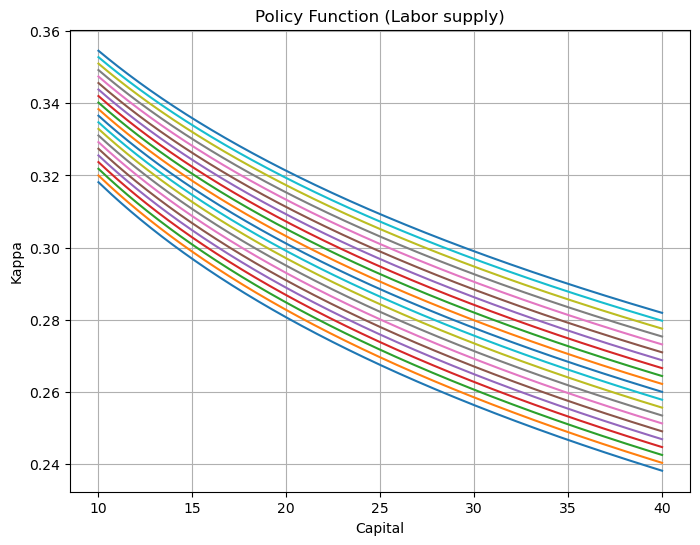

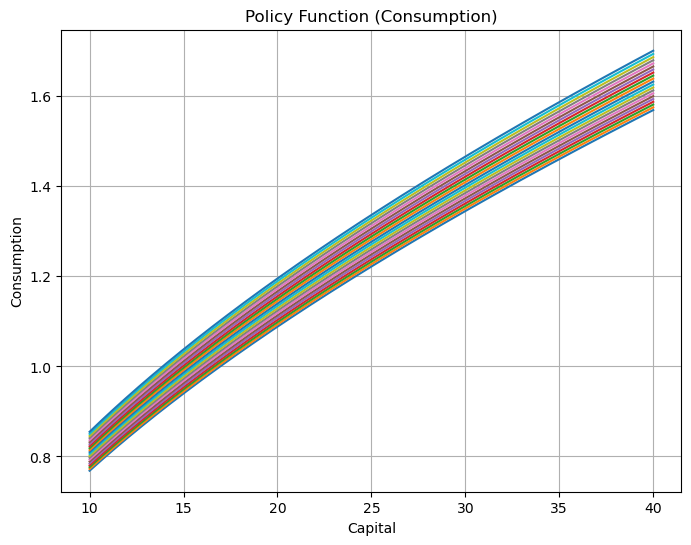

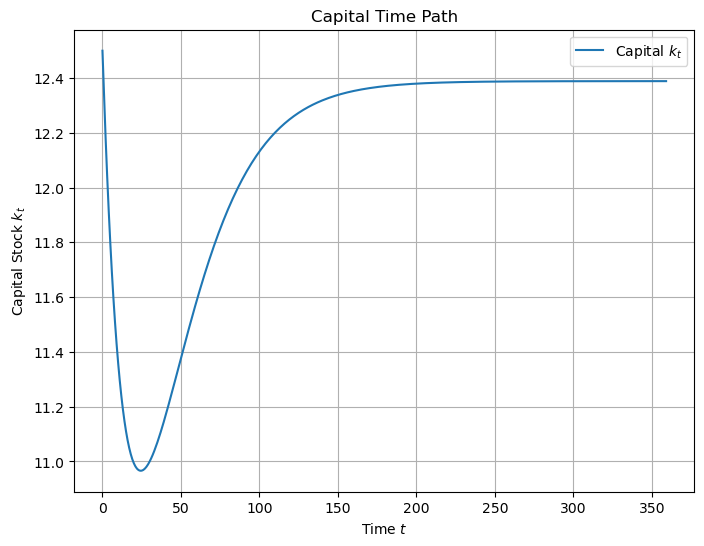

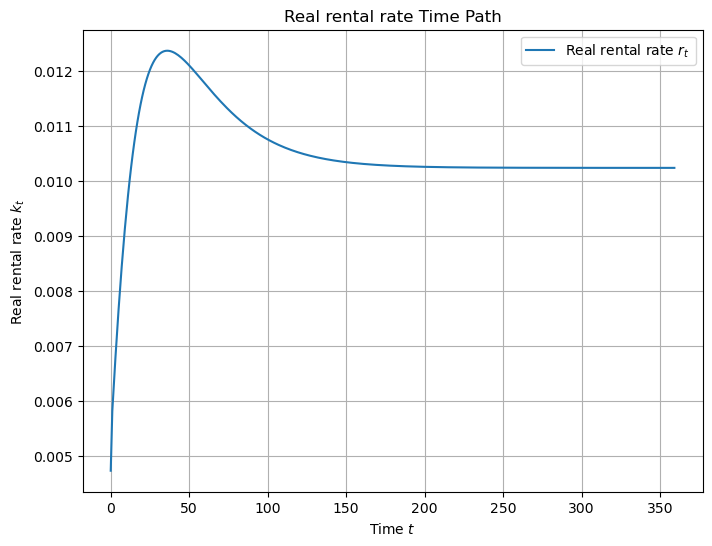

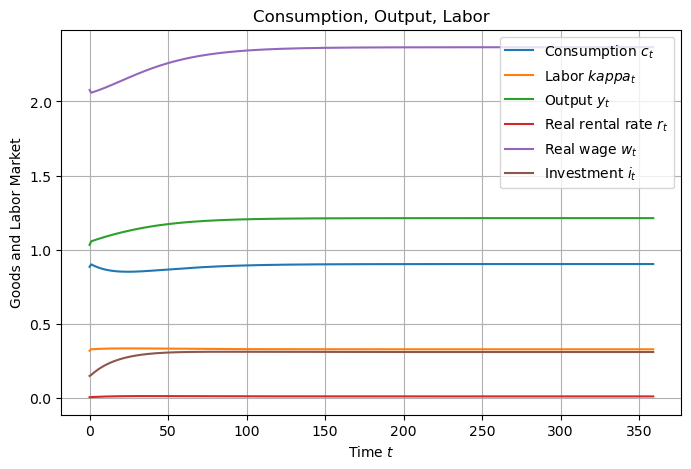

In [197]:
#########################Impluse response #######################################################################

eta_t = np.zeros(TT)
shock_series = simulate_AR(pi, TT, 0)
c_interp = [CubicSpline(grid_k, c[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
l_interp = [CubicSpline(grid_k, l[:, g], bc_type='natural', extrapolate=True) for g in range(eta_dim)]
k_t = np.zeros(TT)
l_t = np.zeros(TT)
r_t = np.zeros(TT)
w_t = np.zeros(TT)
c_t = np.zeros(TT)
i_t = np.zeros(TT)
y_t = np.zeros(TT)
k_t[0] = k0
eta_t[0] = eta_grid[6]
c_t[0] = c_interp[6](k_t[0])
l_t[0] = l_interp[6](k_t[0])
y_t[0] = np.exp(eta_t[0])*k_t[0]**alpha*l_t[0]**(1-alpha)
r_t[0] = np.exp(eta_t[0])*alpha*(l_t[0]/k_t[0])**(1-alpha) - delta
w_t[0] = np.exp(eta_t[0])*(1-alpha)*(k_t[0]/l_t[0])**(alpha)
i_t[0] = y_t[0] - c_t[0]
for it in range(1, TT):
    eta_t[it] = eta_t[it-1]*rho
    k_t[it] = (1-delta)*k_t[it-1] + i_t[it-1]
    c_t[it] = c_interp[state](k_t[it])
    l_t[it] = l_interp[state](k_t[it])
    y_t[it] = np.exp(eta_t[it])*k_t[it]**alpha*l_t[it]**(1-alpha)
    i_t[it] = y_t[it] - c_t[it]
    r_t[it] = np.exp(eta_t[it])*alpha*(l_t[it]/k_t[it])**(1-alpha) - delta
    w_t[it] = np.exp(eta_t[it])*(1-alpha)*(k_t[it]/l_t[it])**(alpha)


print(k_t)

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, l)
plt.title("Policy Function (Labor supply)")
plt.xlabel("Capital")
plt.ylabel("Kappa")
plt.grid(True)
plt.show()

# Plot policy function
plt.figure(figsize=(8, 6))
plt.plot(grid_k, c)
plt.title("Policy Function (Consumption)")
plt.xlabel("Capital")
plt.ylabel("Consumption")
plt.grid(True)
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), k_t, label='Capital $k_t$')
#plt.plot([0, TT-1], [k_stat, k_stat], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Capital Stock $k_t$')
plt.legend()
plt.grid()
plt.title('Capital Time Path')
plt.show()

# Plot time path of capital
plt.figure(figsize=(8, 6))
plt.plot(range(TT), r_t, label='Real rental rate $r_t$')
#plt.plot([0, TT-1], [k_stat, k_stat], 'r--', label='Steady-state $k^*$')
plt.xlabel('Time $t$')
plt.ylabel('Real rental rate $k_t$')
plt.legend()
plt.grid()
plt.title('Real rental rate Time Path')
plt.show()

# Plot time paths for goods market
plt.figure(figsize=(8, 5))
plt.plot(range(TT), c_t, label='Consumption $c_t$')
plt.plot(range(TT), l_t, label='Labor $kappa_t$')
#plt.plot(range(TT), c_t + delta * k_t, label='Consumption + repl. Inv.')
plt.plot(range(TT), y_t, label='Output $y_t$')
plt.plot(range(TT), r_t, label='Real rental rate $r_t$')
plt.plot(range(TT), w_t, label='Real wage $w_t$')
plt.plot(range(TT), i_t, label='Investment $i_t$')
plt.xlabel('Time $t$')
plt.ylabel('Goods and Labor Market')
plt.legend()
plt.grid()
plt.title('Consumption, Output, Labor')
plt.show()